# SegFormer

## Libraries

In [ ]:
!pip install -U \
  transformers==4.41.2 \
  datasets==2.19.0 \
  accelerate==1.7.0

!pip install --upgrade datasets

In [1]:
import os
# os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [18]:
from transformers import pipeline
from transformers import (
    SegformerImageProcessor,
    SegformerForSemanticSegmentation,
    Trainer,
    TrainingArguments,
    default_data_collator,
)
import transformers, accelerate, datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset, DatasetDict
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, resize, to_tensor
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

## Data Preparation

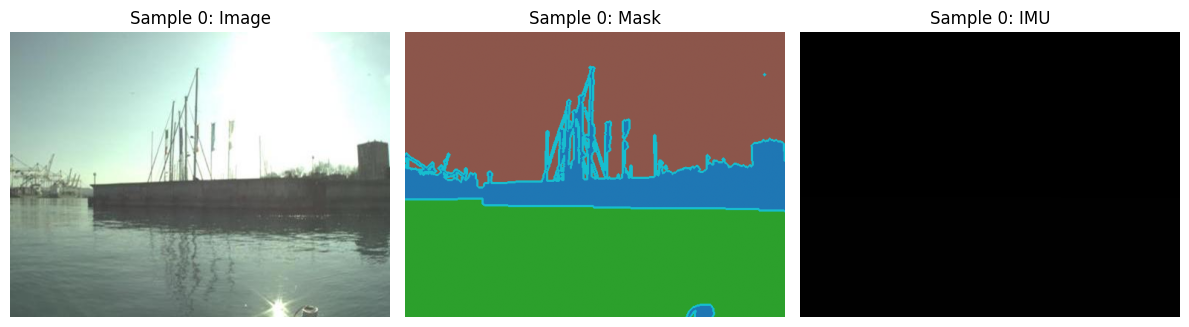

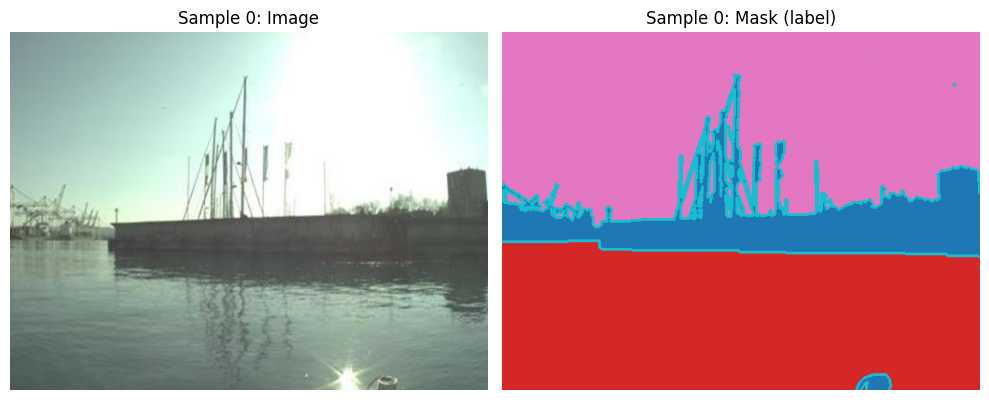

In [3]:
def show_sample(sample, idx):
    img = sample["image"].convert("RGB")
    msk = sample["mask"].convert("L")
    imu = sample["imu"].convert("RGB")

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img)
    axes[0].set_title(f"Sample {idx}: Image")
    axes[0].axis("off")

    axes[1].imshow(msk, cmap="tab10", vmin=0, vmax=4)
    axes[1].set_title(f"Sample {idx}: Mask")
    axes[1].axis("off")

    axes[2].imshow(imu)
    axes[2].set_title(f"Sample {idx}: IMU")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

def visualize_label(sample, idx=0):
    image = sample["image"]
    label = np.array(sample["label"])

    plt.figure(figsize=(10, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Sample {idx}: Image")
    plt.axis("off")

    # Label Mask
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap="tab10", vmin=0, vmax=3)  # vmin/vmax controls color mapping
    plt.title(f"Sample {idx}: Mask (label)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

CLASS_NAMES = {0: "sky", 1: "obstacle", 2: "sea", -100: "None"}

def visualize_labeled_mask(label):
    label = np.array(label)
    masked_label = np.ma.masked_equal(label, -100)
    plt.imshow(masked_label, cmap="tab10", vmin=0, vmax=3)
    plt.colorbar(ticks=[0, 1, 2])
    plt.clim(-0.5, 2.5)
    plt.title("Segmentation Mask (sky, obstacle, sea)")
    plt.axis("off")
    plt.show()

def convert_mask(example):
    label_array = np.array(example["mask"].convert("L"), dtype=np.uint8)
    example["label"] = label_array
    return example

ds = load_dataset("Wilbur1240/MaSTr1325_512x384", split="train")
show_sample(ds[0], 0)
ds = ds.map(convert_mask)
visualize_label(ds[0], idx=0)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


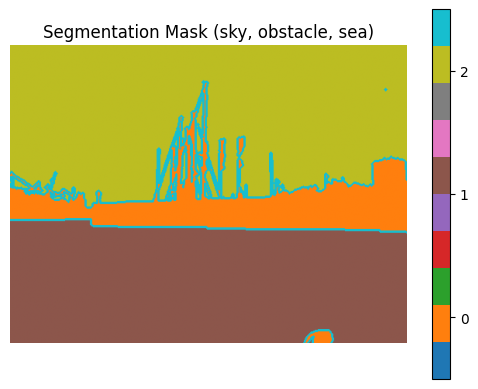

In [4]:
image_processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)

def preprocess(example):
    processed = image_processor(example["image"], return_tensors="pt")
    label_tensor = torch.tensor(example["label"], dtype=torch.long)
    label_tensor = torch.where(
        (label_tensor >= 0) & (label_tensor <= 2),  # 3 = num_labels
        label_tensor,
        torch.tensor(255)
    )
    return {
        "pixel_values": processed["pixel_values"].squeeze(0), # shape: [3, H, W]
        "labels": label_tensor, # shape: [H, W]
    }

tokenized = ds.map(
    preprocess, batched=True, remove_columns=ds.column_names, batch_size=16
)
visualize_labeled_mask(tokenized[0]["labels"])

In [5]:
splits = tokenized.train_test_split(test_size=0.1, seed=42)
train_dataset = splits["train"]
valid_dataset = splits["test"]
tokenized = {
    "train": train_dataset,
    "validation": valid_dataset,
}
raw_splits = ds.train_test_split(test_size=0.1, seed=42)
raw_train_dataset = raw_splits["train"]
raw_valid_dataset = raw_splits["test"]
ds = {
    "train": raw_train_dataset,
    "validation": raw_valid_dataset,
}

## Training

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=3,                    # your classes: water/sky/obstacle
    ignore_mismatched_sizes=True,    # in case you change decoder head size
)

args = TrainingArguments(
    "segformer-maritime",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    remove_unused_columns=False,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    logging_steps=50,
    push_to_hub=False,
    fp16=False
)
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=default_data_collator,
    tokenizer=image_processor,
)

In [ ]:
trainer.train()

## Inference

### Load from checkpoint

In [6]:
image_processor = SegformerImageProcessor.from_pretrained("/workspace/segformer-maritime/checkpoint-2980")
model = SegformerForSemanticSegmentation.from_pretrained(
    "/workspace/segformer-maritime/checkpoint-2980",
    num_labels=3,
    ignore_mismatched_sizes=True,
)

model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

### Inferencing function

In [7]:
def predict_single_sample(model, pixel_values):
    model.eval()
    with torch.no_grad():
        if isinstance(pixel_values, list):
            pixel_values = torch.tensor(pixel_values)
        elif isinstance(pixel_values, np.ndarray):
            pixel_values = torch.from_numpy(pixel_values)
        
        if pixel_values.ndim == 3:
            pixel_values = pixel_values.unsqueeze(0)  # Add batch dim

        pixel_values = pixel_values.to(dtype=torch.float32, device=model.device)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
    
    return preds[0].cpu().numpy()

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise TypeError(f"Unsupported type: {type(x)}")

def rgb_mask_to_label(mask_img, color_map):
    """Convert a PIL RGB segmentation mask into label indices using color_map"""
    mask_np = np.array(mask_img)
    label_mask = np.zeros(mask_np.shape[:2], dtype=np.int32)
    for idx, color in enumerate(color_map):
        matches = np.all(mask_np == color, axis=1)
        label_mask[matches] = idx
    return label_mask

def visualize_prediction(raw_image, raw_mask, pred_mask, color_map=None, id2label=None):
    # --- Image: convert PIL to np.uint8 [H, W, 3] ---
    if isinstance(raw_image, torch.Tensor):
        raw_image = raw_image.permute(1, 2, 0).cpu().numpy()
    elif isinstance(raw_image, np.ndarray):
        pass
    else:
        raw_image = np.array(raw_image.convert("RGB"))
    
    # --- Mask: convert to label indices ---
    if isinstance(raw_mask, torch.Tensor):
        raw_mask = raw_mask.squeeze().cpu().numpy()
    elif isinstance(raw_mask, np.ndarray):
        pass
    else:  # PIL.Image
        raw_mask = np.array(raw_mask)
        if raw_mask.ndim == 3 and raw_mask.shape[2] == 3 and color_map is not None:
            raw_mask = rgb_mask_to_label(raw_mask, color_map)

    # --- Prediction: upsample to raw_mask shape if needed ---
    if pred_mask.shape != raw_mask.shape:
        pred_tensor = torch.tensor(pred_mask).unsqueeze(0).unsqueeze(0).float()
        pred_resized = resize(pred_tensor, size=raw_mask.shape, interpolation=0)
        pred_mask = pred_resized.squeeze().cpu().numpy().astype(int)

    # --- Visualization ---
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(raw_image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(raw_mask, cmap="tab20")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="tab20")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### inferencing

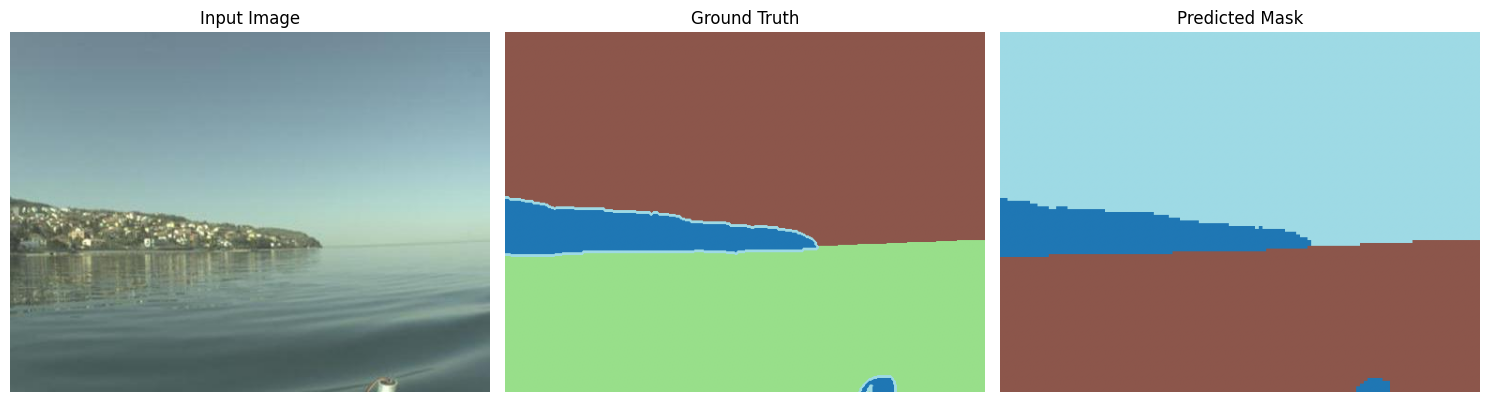

In [12]:
# The RGB values for 3 classes + background
color_map = [
    (0, 255, 0),      # sea
    (0, 0, 255),      # obstacle
    (255, 0, 0),      # sky
    (0, 0, 0)         # background / ignored
]

idx = 3

sample = tokenized["validation"][idx]
pixel_values = sample["pixel_values"]
label = sample["labels"]

pred_mask = predict_single_sample(model, pixel_values)

raw_sample = ds["validation"][idx]
visualize_prediction(raw_sample["image"], raw_sample["mask"], pred_mask, color_map=color_map)


## Evaluation

In [25]:
import cv2
def compute_metrics(preds, labels, num_classes, ignore_index=255):
    resized_preds = []
    
    for pred, label in zip(preds, labels):
        h, w = label.shape
        resized_pred = cv2.resize(pred.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)
        resized_preds.append(resized_pred)
    
    # Convert to flat arrays
    preds_flat = np.array(resized_preds).reshape(-1)
    labels_flat = np.array(labels).reshape(-1)

    # Remove ignored index
    mask = labels_flat != ignore_index
    preds_flat = preds_flat[mask]
    labels_flat = labels_flat[mask]

    # Accuracy
    accuracy = np.mean(preds_flat == labels_flat)

    # Per-class IoU
    ious = []
    for cls in range(num_classes):
        pred_inds = preds_flat == cls
        label_inds = labels_flat == cls
        intersection = np.logical_and(pred_inds, label_inds).sum()
        union = np.logical_or(pred_inds, label_inds).sum()
        iou = intersection / union if union != 0 else float("nan")
        ious.append(iou)

    mean_iou = np.nanmean(ious)

    return {
        "accuracy": accuracy,
        "mean_iou": mean_iou,
        "ious": ious
    }

In [21]:
val_loader = DataLoader(tokenized["validation"], batch_size=1)

all_preds = []
all_labels = []
model.eval()

for batch in tqdm(val_loader):
    pixel_values = batch["pixel_values"]
    if isinstance(pixel_values, list):
        pixel_values = torch.tensor(pixel_values)
    elif isinstance(pixel_values, np.ndarray):
        pixel_values = torch.from_numpy(pixel_values)
    
    if pixel_values.ndim == 3:
        pixel_values = pixel_values.unsqueeze(0)

    pixel_values = pixel_values.to(dtype=torch.float32, device=model.device)

    labels = batch["labels"] # shape: [H, W]
    if isinstance(labels, list):
        labels = np.array(labels)
    labels = np.squeeze(labels)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits  # shape: [1, num_classes, H, W]
        preds = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

    all_preds.append(preds)
    all_labels.append(labels)

100%|██████████| 133/133 [15:15<00:00,  6.88s/it]


In [26]:
metrics = compute_metrics(
    preds=np.array(all_preds),
    labels=np.array(all_labels),
    num_classes=3,
    ignore_index=255
)

print("✅ Validation Accuracy:", metrics["accuracy"])
print("✅ Mean IoU:", metrics["mean_iou"])
print("✅ Per-Class IoU:", metrics["ious"])

✅ Validation Accuracy: 0.9968138998993795
✅ Mean IoU: 0.9856568599892793
✅ Per-Class IoU: [np.float64(0.9650265418647269), np.float64(0.9952078900931072), np.float64(0.9967361480100037)]
